In [1]:
import argparse
import math
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_, compare_models_on_measure
from src.gradient_masking_tests import gradient_norm, fgsm_pgd_cos_dif, multi_scale_fgsm, gradient_information, linearization_error
import eagerpy as ep
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, CUREResNet18
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers, src.gradient_masking_tests

In [2]:
# setup
device = torch.device("cpu")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='../data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='../data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load CIFAR-10 models

In [3]:
# # Regular CIFAR-10  ResNet Model
model = CIFAR_Res_Net().eval().to(device)
model.load_state_dict(torch.load("../models/normal_20e.model", map_location=device))
# CIFAR-10  ResNet Model trained with pgd 03
pgd_model = CIFAR_Res_Net().to(device).eval()
pgd_model.load_state_dict(torch.load("../models/pgd_e8_20e.model", map_location=device))
#CIFAR-10  ResNet Model trained with pgd 06
pgd_model_6 = CIFAR_Res_Net().to(device).eval()
pgd_model_6.load_state_dict(torch.load("../models/pgd_e16_20e.model", map_location=device))
#CIFAR-10  ResNet Model trained with large FGSM steps
fgsm_model = CIFAR_Res_Net().to(device).eval()
fgsm_model.load_state_dict(torch.load("../models/fgsm_e16_20e.model", map_location=device))
# # # # CIFAR-10  ResNet Model trained with small FGSM steps
fgsm_model_small = CIFAR_Res_Net().to(device).eval()
fgsm_model_small.load_state_dict(torch.load("../models/fgsm_e8_20e.model", map_location=device))
# # # CIFAR-10  ResNet Model trained with large Step-ll steps
step_ll_model = CIFAR_Res_Net().to(device).eval()
step_ll_model.load_state_dict(torch.load("../models/step_ll_e16_20e.model", map_location=device))
# # # CIFAR-10  ResNet Model trained with small Step-ll steps
step_ll_model_small = CIFAR_Res_Net().to(device).eval()
step_ll_model_small.load_state_dict(torch.load("../models/step_ll_e8_20e.model", map_location=device))
# # CIFAR-10  ResNet Model trained through Jacobian regularization ld0.1
jac_norm_model = CIFAR_Res_Net().to(device).eval()
jac_norm_model.load_state_dict(torch.load("../models/grad_reg_ld01_20e.model", map_location=device))
## Pretrained CIFAR-10 RESNET trained using CURE
cure = CUREResNet18().to(device).eval()
cure[1].load_state_dict(torch.load("../models/RN18_CURE.pth", map_location=device)['net'])

models = [model, step_ll_model, step_ll_model_small, fgsm_model, fgsm_model_small, pgd_model_6, pgd_model, jac_norm_model, cure]
names = ['normal', 'step ll', 'step ll small', 'fgsm', 'fgsm small', 'pgd', 'pgd small', 'grad norm', 'cure']

### Check gradient norms
Gradients seem to blow up after FGSM training

In [11]:
subset_size = 5000
train_subset = torch.utils.data.Subset(train_dataset, np.random.randint(0, len(train_dataset), size=subset_size).tolist())
train_subset_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

test_subset = torch.utils.data.Subset(test_dataset, np.random.randint(0, len(test_dataset), size=subset_size).tolist())
test_subset_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)

In [12]:
def show_grad_histogram(model, data_loader, device='cpu'):
    norm = gradient_norm(model, data_loader, device=device).detach().cpu().numpy()
    plt.hist(norm, bins=100)
    plt.show()
    print("Max: {}, Min: {}, Mean: {}, Median: {}".format(norm.max(), norm.min(), norm.mean(), np.median(norm)))

def compare_models_grad(models, labels, data_loader, device='cpu', height=2):
    norms = [gradient_norm(model, data_loader, device=device).detach().cpu().numpy() for model in models]
    width = math.ceil(len(models)/height)
    fig, ax = plt.subplots(height, width, figsize=(15, 15))
    for index, norm in enumerate(norms):
        axis = ax[index//width, index%width]
        axis.hist(norm, bins=100)
        axis.set_title(labels[index])
        axis.text(0.5, -0.13, "Max: {:.6f}, Min: {:.6f}, \nMean: {:.6f}, Median: {:.6f}".format(norm.max().item(), norm.min().item(), norm.mean().item(), np.median(norm).item()),
                                            size=12, ha="center", transform=axis.transAxes)
    plt.show()

### Using train dataset

In [ ]:
compare_models_on_measure(gradient_norm, models, names, train_subset_loader, device=device, height=3)

### Using test dataset

In [ ]:
compare_models_on_measure(gradient_norm, models, names, test_subset_loader, device=device, height=3)

## Cosine difference between FGSM and PGD

### Using train dataset

Epsilon 0.03 -- Cos Sim: 0.31442099809646606, FGSM success: 1.0, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.17456474900245667, FGSM success: 1.0, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.34315070509910583, FGSM success: 0.0, PGD Success: 0.5
Epsilon 0.06 -- Cos Sim: 0.1930745393037796, FGSM success: 0.0, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.6577003598213196, FGSM success: 0.4000000059604645, PGD Success: 0.699999988079071
Epsilon 0.06 -- Cos Sim: 0.5555945038795471, FGSM success: 1.0, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.08605409413576126, FGSM success: 0.0, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.027024060487747192, FGSM success: 0.0, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.06057499721646309, FGSM success: 0.10000000149011612, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.03768140822649002, FGSM success: 0.4000000059604645, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.7710011601448059, FGSM success: 0.4000000059604645, PGD Success: 0.30000001192092896
Epsilon 0.

<AxesSubplot:xlabel='model', ylabel='value'>

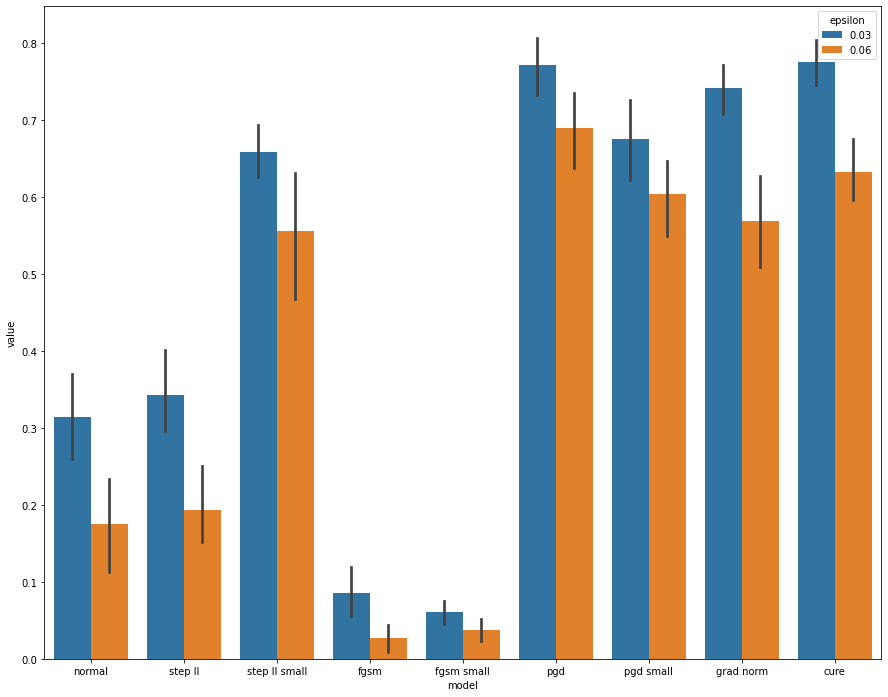

In [8]:
cos_dif_data = [fgsm_pgd_cos_dif(cur_model, train_dataset, epsilons=[0.03, 0.06], subset_size=10, batch_size=batch_size, device=device, return_adjusted_fgsm=False) for cur_model in models]
cos_dif_data = [pd.DataFrame(data) for data in cos_dif_data]
for name, data in zip(names, cos_dif_data):
    data['model'] = name

long_form_cos_dif_data = pd.melt(pd.concat(cos_dif_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_cos_dif_data, x='model', y='value', hue='epsilon')

### Using test dataset

Epsilon 0.03 -- Cos Sim: 0.3516506552696228, FGSM success: 1.0, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.2357897311449051, FGSM success: 1.0, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.29814526438713074, FGSM success: 0.30000001192092896, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.1832691729068756, FGSM success: 0.5, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.6512400507926941, FGSM success: 0.699999988079071, PGD Success: 0.800000011920929
Epsilon 0.06 -- Cos Sim: 0.5123421549797058, FGSM success: 1.0, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.07972468435764313, FGSM success: 0.0, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.0289151631295681, FGSM success: 0.10000000149011612, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.060468025505542755, FGSM success: 0.30000001192092896, PGD Success: 1.0
Epsilon 0.06 -- Cos Sim: 0.037927500903606415, FGSM success: 0.10000000149011612, PGD Success: 1.0
Epsilon 0.03 -- Cos Sim: 0.7892262935638428, FGSM success: 0.6000000238418579, PGD Success: 

<AxesSubplot:xlabel='model', ylabel='value'>

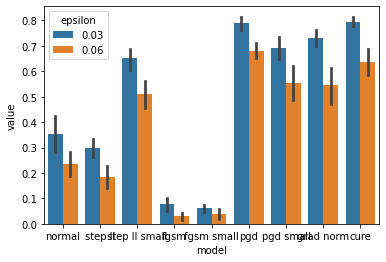

In [9]:
cos_dif_data = [fgsm_pgd_cos_dif(cur_model, test_dataset, epsilons=[0.03, 0.06], subset_size=10, batch_size=batch_size, device=device, return_adjusted_fgsm=False) for cur_model in models]
cos_dif_data = [pd.DataFrame(data) for data in cos_dif_data]
for name, data in zip(names, cos_dif_data):
    data['model'] = name

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_cos_dif_data, x='model', y='value', hue='epsilon')

## Linearizability of Model

#### Training data

In [33]:
linearization_data = [linearization_error(cur_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1], subset=1000, batch_size=32, n_perturbations=32, device=device) for cur_model in models]
linearization_data = [pd.DataFrame(data) for data in linearization_data]
for name, data in zip(names, linearization_data):
    data['model'] = name

long_form_data = pd.melt(pd.concat(linearization_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_data, x='model', y='value', hue='epsilon')

normal: 
Epsilon 0.003: 0.03307342529296875 error
Epsilon 0.03: 0.3565625548362732 error
Epsilon 0.06: 1.566001057624817 error
Epsilon 0.1: 8.340760231018066 error
step ll: 
Epsilon 0.003: 0.023074664175510406 error
Epsilon 0.03: 0.2147114872932434 error
Epsilon 0.06: 0.383059561252594 error
Epsilon 0.1: 0.7022789716720581 error
step ll small: 
Epsilon 0.003: 0.006576708983629942 error
Epsilon 0.03: 0.06567896157503128 error
Epsilon 0.06: 0.1467602550983429 error
Epsilon 0.1: 0.32411131262779236 error
fgsm: 
Epsilon 0.003: 0.14247646927833557 error
Epsilon 0.03: 1.473429799079895 error
Epsilon 0.06: 2.972611665725708 error
Epsilon 0.1: 23.294282913208008 error
fgsm small: 
Epsilon 0.003: 0.00502273952588439 error
Epsilon 0.03: 0.04990667477250099 error
Epsilon 0.06: 0.14848743379116058 error
Epsilon 0.1: 0.24841904640197754 error
pgd: 
Epsilon 0.003: 0.00624723918735981 error
Epsilon 0.03: 0.06239868700504303 error
Epsilon 0.06: 0.262955904006958 error
Epsilon 0.1: 0.3219253718852997 e

#### Testing data

In [34]:
linearization_data = [linearization_error(cur_model, test_dataset, epsilons=[0.003, 0.03, 0.06, 0.1], subset=1000, batch_size=32, n_perturbations=32, device=device) for cur_model in models]
linearization_data = [pd.DataFrame(data) for data in linearization_data]
for name, data in zip(names, linearization_data):
    data['model'] = name

long_form_data = pd.melt(pd.concat(linearization_data), id_vars=['model'], var_name='epsilon')

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(ax=ax, data=long_form_data, x='model', y='value', hue='epsilon')

normal: 
Epsilon 0.003: 0.0717787966132164 error
Epsilon 0.03: 1.0048729181289673 error
Epsilon 0.06: 5.74287748336792 error
Epsilon 0.1: 16.59425926208496 error
step ll: 
Epsilon 0.003: 0.05241377279162407 error
Epsilon 0.03: 0.6117618680000305 error
Epsilon 0.06: 1.2578635215759277 error
Epsilon 0.1: 3.018287420272827 error
step ll small: 
Epsilon 0.003: 0.0216224268078804 error
Epsilon 0.03: 0.17331956326961517 error
Epsilon 0.06: 0.752302348613739 error
Epsilon 0.1: 1.4778895378112793 error
fgsm: 
Epsilon 0.003: 0.18380463123321533 error
Epsilon 0.03: 2.4682137966156006 error
Epsilon 0.06: 10.37920093536377 error
Epsilon 0.1: 38.12845230102539 error
fgsm small: 
Epsilon 0.003: 0.014814087189733982 error
Epsilon 0.03: 0.17861822247505188 error
Epsilon 0.06: 0.4336315989494324 error
Epsilon 0.1: 0.929533839225769 error
pgd: 
Epsilon 0.003: 0.008690240792930126 error
Epsilon 0.03: 0.13644909858703613 error
Epsilon 0.06: 0.24094991385936737 error
Epsilon 0.1: 0.7786321043968201 error
p

## Gradient Information

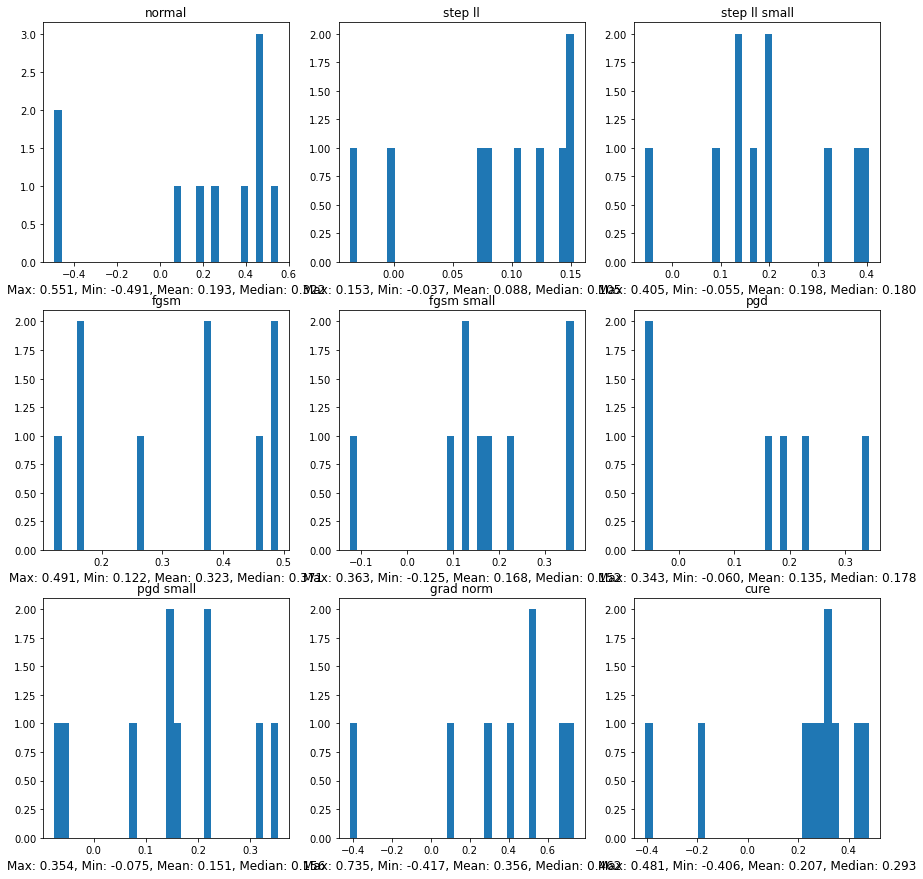

In [86]:
compare_models_on_measure(gradient_information, models, names, train_dataset, iters=5, height=4, bins=30, device=device, subset_size=10)

#### Training data

In [31]:
compare_models_on_measure(gradient_information, models, names, train_dataset, iters=5, height=4, bins=30, device=device, subset_size=5000)

normal: 0.08381164073944092
step ll: 0.01806812360882759
step ll small: 0.0999184250831604
fgsm: 0.11507304757833481
fgsm small: 0.03936716541647911
pgd: 0.04062598943710327
pgd small: 0.05712084844708443
grad norm: 0.1348295509815216
cure: 0.07283072918653488


#### Testing data

In [32]:
compare_models_on_measure(gradient_information, models, names, test_dataset, iters=5, height=4, bins=30, device=device, subset_size=5000)

normal: 0.10207227617502213
step ll: 0.03300695866346359
step ll small: 0.0948532372713089
fgsm: 0.11606040596961975
fgsm small: 0.042634010314941406
pgd: 0.026364196091890335
pgd small: 0.03546912968158722
grad norm: 0.13850928843021393
cure: 0.0751025527715683


### PGD Colinearity

In [93]:
colinearity = pd.read_csv("../pgd_colinearity.csv")
colinearity = colinearity.drop(columns=[colinearity.columns[0]])

In [94]:
long_form_data = colinearity.drop(columns=['mean', 'sum']).melt(id_vars=['model'])

<AxesSubplot:xlabel='variable', ylabel='value'>

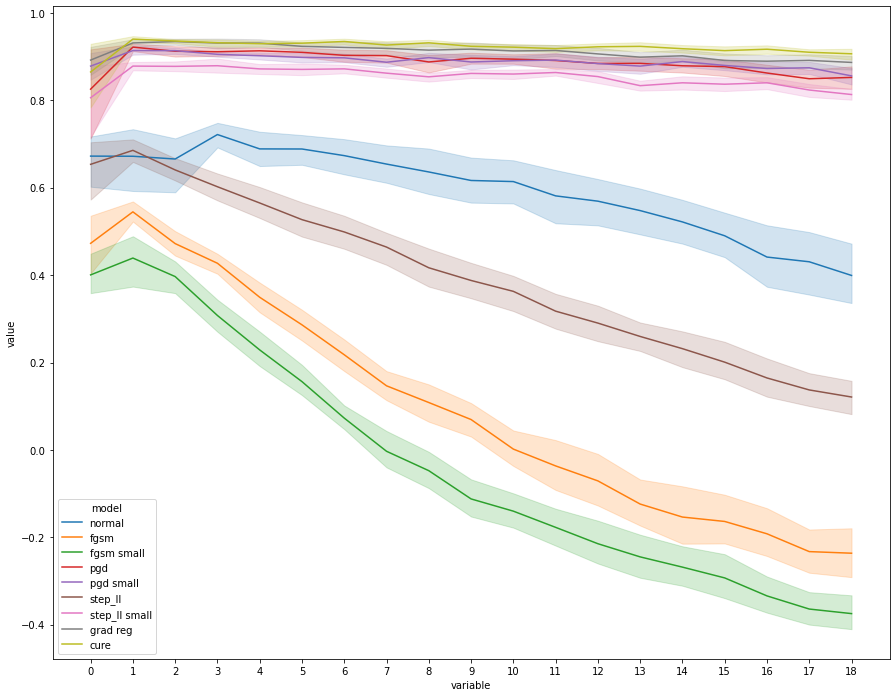

In [95]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(ax=ax, data=long_form_data, x='variable', y='value', hue='model')

<AxesSubplot:xlabel='model', ylabel='mean'>

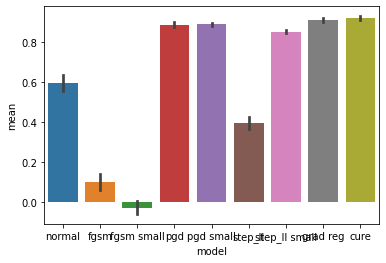

In [96]:
sns.barplot(data=colinearity, x='model', y='mean')

In [97]:
less_than_zero = colinearity.drop(columns=['model', 'sum', 'mean']) < 0
cut_off_data = colinearity.drop(columns=['model', 'sum', 'mean'])
cut_off_data[less_than_zero] = np.NaN
cut_off_data['mean'] = cut_off_data.mean(axis=1, skipna=True)

<AxesSubplot:xlabel='model', ylabel='mean'>

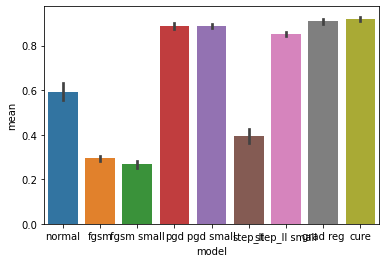

In [98]:
cut_off_data['model'] = colinearity['model']
sns.barplot(data=cut_off_data, x='model', y='mean')

### PGD Colinearity - non sequential

In [100]:
colinearity = pd.read_csv("../pgd_colinearity_non_sequential.csv")
colinearity = colinearity.drop(columns=[colinearity.columns[0]])

In [101]:
long_form_data = colinearity.drop(columns=['mean', 'sum']).melt(id_vars=['model'])

<AxesSubplot:xlabel='variable', ylabel='value'>

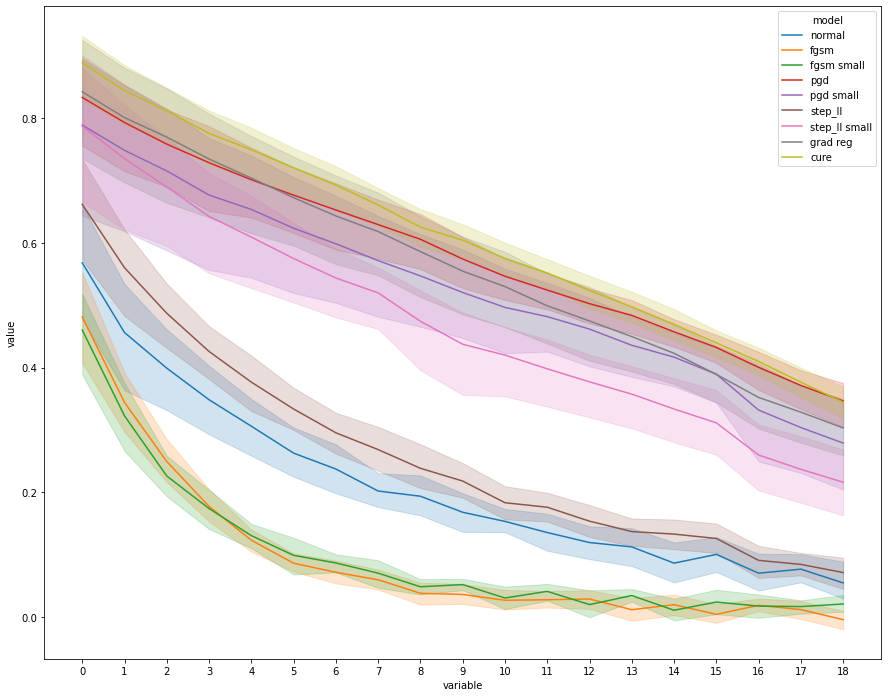

In [102]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(ax=ax, data=long_form_data, x='variable', y='value', hue='model')

<AxesSubplot:xlabel='model', ylabel='mean'>

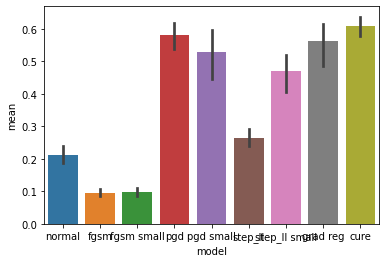

In [103]:
sns.barplot(data=colinearity, x='model', y='mean')

In [104]:
less_than_zero = colinearity.drop(columns=['model', 'sum', 'mean']) < 0
cut_off_data = colinearity.drop(columns=['model', 'sum', 'mean'])
cut_off_data[less_than_zero] = np.NaN
cut_off_data['mean'] = cut_off_data.mean(axis=1, skipna=True)

<AxesSubplot:xlabel='model', ylabel='mean'>

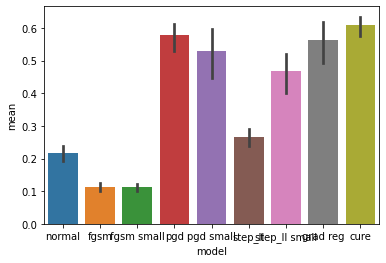

In [105]:
cut_off_data['model'] = colinearity['model']
sns.barplot(data=cut_off_data, x='model', y='mean')